In [0]:
import tensorflow as tf
from tensorflow.keras import Sequential,layers
from tensorflow.keras.models import save_model
from tqdm.notebook import tqdm
from pathlib import Path
import statistics
import numpy as np
from sklearn import neighbors,metrics
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.ensemble import AdaBoostClassifier
import sklearn
import pandas as pd
import math
import warnings
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importance of Project


Our project goal is to predict the number of installs of apps by looking at app info and it’s reviews. We hope that this project will be helpful to app developers who need to predict their number of installs or to investors who want to pickout the next big app. Companies may run beta focus groups or app developers may receive feedback from testers and get certain amounts of reviews. We use this and some knowledge about the app to predict its success. Knowing the number of installs can be very helpful to developers and business managers because they can predict the profit. The result of this project may show the importance of reviews to apps in the market as it could be one of  the determining factors for the number of installs.

#What will be done? 

Data science can be summarized in to five steps: capture, maintain, process, analyze and communicate. We gather the data that has meaningful variable leading to appropriate classes. Then clean the data in a way that it is easy for computer to read and process modelling. We apply algorithms to train model and test it using the set of data acquired above and analyze the performance of model. We then view the results and atempt to extract any relevent learning or information.



##License
This work is licensed under the Creative Commons Attribution 3.0 Unported License. To view a copy of this license, visit http://creativecommons.org/licenses/by/3.0/.

#Data Cleaning

There two datasets from kaggle(https://www.kaggle.com/lava18/google-play-store-apps) for app reviews, one is the list of apps with information. It has information such as app name, category, rating and more. And the other is a list of reviews for each app with sentiment if that particular content of review was positive, neutral or negative. We could not directly use these two files as they are not joined.

First, we have analysed which information column is irrelevant to the number of installs of the app. It was done by common sense. We removed size, last updated date, current version and android version because they are not the factor that would affect the number of installs before publishing. Also, we have removed rating and number of reviews because they are obviously associated with app installs and they would not be known before publishing. Then we also trimed our data of any out of place characters.

We combined Category and Genre by categorizing common key words and added the list of the key categories to columns so that each app’s attributes for category/genre can be expressed as true or false. Moreover, we have gathered the sentiment of reviews for each app and calculated the total number of positive, neutral and negative to get the percentages. Finally we combined those three columns to the existing app list. 



In [0]:
AppInfo = pd.read_csv("drive/My Drive/CS3481Project2/googleplaystore.csv",sep = ',')
AppInfo.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [0]:
Review_info = pd.read_csv("drive/My Drive/CS3481Project2/googleplaystore_user_reviews.csv",sep = ',')
Review_info

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
...,...,...,...,...,...
64290,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64291,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64292,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64293,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN


##Bad Values

In [0]:
AppInfo.loc[AppInfo.Installs == "Free"]
AppInfo=AppInfo.drop(10472,axis=0)
Review_info.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

###Spliting Binary values

In [0]:
def to_binary_columns(data,column,positive_values):
  def match(x,y):
    if(str(x) in y):
      return 1
    else:
      return 0
  data[column] = data[column].apply(match,args = positive_values) 
  data = data.drop(column,axis = 1)
  return AppInfo

In [0]:
AppInfo = to_binary_columns(AppInfo,"Type",["Free"])

##Clean text values

In [0]:
def clean_category_labels(x):
  words = x.split("_")
  for w in range(len(words)):
    words[w] = words[w].capitalize()
  return " ".join(words).replace("And","&")

In [0]:
AppInfo["Category"] = AppInfo["Category"].apply(clean_category_labels)
AppInfo['Cat&Genres'] = AppInfo["Genres"].str.cat(AppInfo['Category'],sep=";")

###Split Catagorical Values

In [0]:
def catagories_to_columns(data,column,unique = None ):
  def match(x,y):
    x_list=x.split(';')
    if(y in x_list):
      return 1
    else:
      return 0
  if(unique==None):
    unique = list(set(data[column]))
  for label in unique:
    data[column+"="+str(label)] = data[column].apply(match, args = (label,))
  data = data.drop(column,axis = 1)
  return data
def uniuqe_of_list_list(list_list):
  extracted = []
  for single_list in list_list:
    x = single_list.split(';')
    extracted = extracted + x
  extracted= list(set(extracted))
  return extracted
  

In [0]:

AppInfo = catagories_to_columns(AppInfo,"Cat&Genres",unique=uniuqe_of_list_list(list(set(AppInfo["Cat&Genres"]))))
AppInfo = catagories_to_columns(AppInfo,"Content Rating")

Review_info = catagories_to_columns(Review_info,'Sentiment')

##Clean Numerical values

In [0]:
def rating_filter(x, nan_default = 0.0):
  if(math.isnan(x)):
    return nan_default
  return float(x)
  
def remove_sign(x):
    x = x.replace('$','')
    return float(x)
def clean_installs(x):
  return int(x.replace(",","").replace("+",""))




In [0]:
AppInfo["Rating"] = AppInfo["Rating"].apply(rating_filter)
AppInfo["Price"] = AppInfo["Price"].apply(remove_sign)
AppInfo["Installs"] = AppInfo["Installs"].apply(clean_installs)

##Droping Columns

In [0]:
def dropColumn(data,columns):
  data.drop(columns = columns,axis = 1,inplace=True)
  return data

In [0]:
AppInfo = dropColumn(AppInfo,["Size","Last Updated","Current Ver","Android Ver","Reviews","Rating"])
AppInfo = dropColumn(AppInfo,["Category","Genres"])
Review_info = dropColumn(Review_info,['Translated_Review', 'Sentiment_Polarity', 'Sentiment_Subjectivity'])


##Mergeing Rows

In [0]:
Review_info = Review_info.groupby('App', as_index=False).mean()

In [0]:
AppInfo.tail()

,App,Installs,Type,Price,Cat&Genres=Shopping,Cat&Genres=Food & Drink,Cat&Genres=Adventure,Cat&Genres=Music,Cat&Genres=Beauty,Cat&Genres=Puzzle,Cat&Genres=Parenting,Cat&Genres=Trivia,Cat&Genres=Casual,Cat&Genres=Educational,Cat&Genres=Video Players,Cat&Genres=Personalization,Cat&Genres=Casino,Cat&Genres=Health & Fitness,Cat&Genres=Action,Cat&Genres=Arcade,Cat&Genres=Books & Reference,Cat&Genres=Auto & Vehicles,Cat&Genres=Photography,Cat&Genres=Music & Video,Cat&Genres=Dating,Cat&Genres=Racing,Cat&Genres=Communication,Cat&Genres=Business,Cat&Genres=Card,Cat&Genres=Board,Cat&Genres=Events,Cat&Genres=Art & Design,Cat&Genres=Tools,Cat&Genres=Game,Cat&Genres=Pretend Play,Cat&Genres=Lifestyle,Cat&Genres=Video Players & Editors,Cat&Genres=Libraries & Demo,Cat&Genres=Strategy,Cat&Genres=Productivity,Cat&Genres=Music & Audio,Cat&Genres=Entertainment,Cat&Genres=Travel & Local,Cat&Genres=House & Home,Cat&Genres=News & Magazines,Cat&Genres=Family,Cat&Genres=Social,Cat&Genres=Maps & Navigation,Cat&Genres=Brain Games,Cat&Genres=Education,Cat&Genres=Sports,Cat&Genres=Word,Cat&Genres=Finance,Cat&Genres=Weather,Cat&Genres=Comics,Cat&Genres=Simulation,Cat&Genres=Medical,Cat&Genres=Role Playing,Cat&Genres=Action & Adventure,Cat&Genres=Creativity,Content Rating=Unrated,Content Rating=Everyone,Content Rating=Teen,Content Rating=Adults only 18+,Content Rating=Mature 17+,Content Rating=Everyone 10+
10836,Sya9a Maroc - FR,5000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10837,Fr. Mike Schmitz Audio Teachings,100,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10838,Parkinson Exercices FR,1000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
10839,The SCP Foundation DB fr nn5n,1000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10840,iHoroscope - 2018 Daily Horoscope & Astrology,10000000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [0]:
Review_info.head()

,App,Sentiment=Positive,Sentiment=Neutral,Sentiment=Negative
0,10 Best Foods for You,0.835052,0.113402,0.051546
1,104 找工作 - 找工作 找打工 找兼職 履歷健檢 履歷診療室,0.775000,0.200000,0.025000
2,11st,0.589744,0.230769,0.179487
3,1800 Contacts - Lens Store,0.800000,0.125000,0.075000
4,1LINE – One Line with One Touch,0.710526,0.078947,0.210526


In [0]:
FinalData = AppInfo.merge(Review_info, on='App')
FinalData.reset_index(inplace=True)
FinalData = dropColumn(FinalData,["App","index"])
FinalData

,Installs,Type,Price,Cat&Genres=Shopping,Cat&Genres=Food & Drink,Cat&Genres=Adventure,Cat&Genres=Music,Cat&Genres=Beauty,Cat&Genres=Puzzle,Cat&Genres=Parenting,Cat&Genres=Trivia,Cat&Genres=Casual,Cat&Genres=Educational,Cat&Genres=Video Players,Cat&Genres=Personalization,Cat&Genres=Casino,Cat&Genres=Health & Fitness,Cat&Genres=Action,Cat&Genres=Arcade,Cat&Genres=Books & Reference,Cat&Genres=Auto & Vehicles,Cat&Genres=Photography,Cat&Genres=Music & Video,Cat&Genres=Dating,Cat&Genres=Racing,Cat&Genres=Communication,Cat&Genres=Business,Cat&Genres=Card,Cat&Genres=Board,Cat&Genres=Events,Cat&Genres=Art & Design,Cat&Genres=Tools,Cat&Genres=Game,Cat&Genres=Pretend Play,Cat&Genres=Lifestyle,Cat&Genres=Video Players & Editors,Cat&Genres=Libraries & Demo,Cat&Genres=Strategy,Cat&Genres=Productivity,Cat&Genres=Music & Audio,Cat&Genres=Entertainment,Cat&Genres=Travel & Local,Cat&Genres=House & Home,Cat&Genres=News & Magazines,Cat&Genres=Family,Cat&Genres=Social,Cat&Genres=Maps & Navigation,Cat&Genres=Brain Games,Cat&Genres=Education,Cat&Genres=Sports,Cat&Genres=Word,Cat&Genres=Finance,Cat&Genres=Weather,Cat&Genres=Comics,Cat&Genres=Simulation,Cat&Genres=Medical,Cat&Genres=Role Playing,Cat&Genres=Action & Adventure,Cat&Genres=Creativity,Content Rating=Unrated,Content Rating=Everyone,Content Rating=Teen,Content Rating=Adults only 18+,Content Rating=Mature 17+,Content Rating=Everyone 10+,Sentiment=Positive,Sentiment=Neutral,Sentiment=Negative
0,500000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.590909,0.090909,0.318182
1,500000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.590909,0.090909,0.318182
2,1000000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.711111,0.177778,0.111111
3,5000000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.000000,0.000000,0.000000
4,100000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.605263,0.263158,0.131579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,1000000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.684211,0.157895,0.157895
1225,100000000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.461538,0.000000,0.538462
1226,5000000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.730769,0.134615,0.134615
1227,10000000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0.753623,0.014493,0.231884


In [0]:
FinalData.to_csv("drive/My Drive/CS3481Project2/basic_cleaned_google_app_data.csv",index=False)
FinalData.head()

,Installs,Type,Price,Cat&Genres=Shopping,Cat&Genres=Food & Drink,Cat&Genres=Adventure,Cat&Genres=Music,Cat&Genres=Beauty,Cat&Genres=Puzzle,Cat&Genres=Parenting,Cat&Genres=Trivia,Cat&Genres=Casual,Cat&Genres=Educational,Cat&Genres=Video Players,Cat&Genres=Personalization,Cat&Genres=Casino,Cat&Genres=Health & Fitness,Cat&Genres=Action,Cat&Genres=Arcade,Cat&Genres=Books & Reference,Cat&Genres=Auto & Vehicles,Cat&Genres=Photography,Cat&Genres=Music & Video,Cat&Genres=Dating,Cat&Genres=Racing,Cat&Genres=Communication,Cat&Genres=Business,Cat&Genres=Card,Cat&Genres=Board,Cat&Genres=Events,Cat&Genres=Art & Design,Cat&Genres=Tools,Cat&Genres=Game,Cat&Genres=Pretend Play,Cat&Genres=Lifestyle,Cat&Genres=Video Players & Editors,Cat&Genres=Libraries & Demo,Cat&Genres=Strategy,Cat&Genres=Productivity,Cat&Genres=Music & Audio,Cat&Genres=Entertainment,Cat&Genres=Travel & Local,Cat&Genres=House & Home,Cat&Genres=News & Magazines,Cat&Genres=Family,Cat&Genres=Social,Cat&Genres=Maps & Navigation,Cat&Genres=Brain Games,Cat&Genres=Education,Cat&Genres=Sports,Cat&Genres=Word,Cat&Genres=Finance,Cat&Genres=Weather,Cat&Genres=Comics,Cat&Genres=Simulation,Cat&Genres=Medical,Cat&Genres=Role Playing,Cat&Genres=Action & Adventure,Cat&Genres=Creativity,Content Rating=Unrated,Content Rating=Everyone,Content Rating=Teen,Content Rating=Adults only 18+,Content Rating=Mature 17+,Content Rating=Everyone 10+,Sentiment=Positive,Sentiment=Neutral,Sentiment=Negative
0,500000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.590909,0.090909,0.318182
1,500000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.590909,0.090909,0.318182
2,1000000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.711111,0.177778,0.111111
3,5000000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.000000,0.000000,0.000000
4,100000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.605263,0.263158,0.131579


#Advanced Data Cleaning

We know that this dataset contains a lot of outliers. Outliers can be difficult as if not enough cases exist in both training and test sets. The model will have no way of being able to predict how to solve these cases. It is similar to predicting that coin flips will always be heads just because the first two coin flip are both heads.

In [0]:
FinalData.describe()

,Installs,Type,Price,Cat&Genres=Shopping,Cat&Genres=Food & Drink,Cat&Genres=Adventure,Cat&Genres=Music,Cat&Genres=Beauty,Cat&Genres=Puzzle,Cat&Genres=Parenting,Cat&Genres=Trivia,Cat&Genres=Casual,Cat&Genres=Educational,Cat&Genres=Video Players,Cat&Genres=Personalization,Cat&Genres=Casino,Cat&Genres=Health & Fitness,Cat&Genres=Action,Cat&Genres=Arcade,Cat&Genres=Books & Reference,Cat&Genres=Auto & Vehicles,Cat&Genres=Photography,Cat&Genres=Music & Video,Cat&Genres=Dating,Cat&Genres=Racing,Cat&Genres=Communication,Cat&Genres=Business,Cat&Genres=Card,Cat&Genres=Board,Cat&Genres=Events,Cat&Genres=Art & Design,Cat&Genres=Tools,Cat&Genres=Game,Cat&Genres=Pretend Play,Cat&Genres=Lifestyle,Cat&Genres=Video Players & Editors,Cat&Genres=Libraries & Demo,Cat&Genres=Strategy,Cat&Genres=Productivity,Cat&Genres=Music & Audio,Cat&Genres=Entertainment,Cat&Genres=Travel & Local,Cat&Genres=House & Home,Cat&Genres=News & Magazines,Cat&Genres=Family,Cat&Genres=Social,Cat&Genres=Maps & Navigation,Cat&Genres=Brain Games,Cat&Genres=Education,Cat&Genres=Sports,Cat&Genres=Word,Cat&Genres=Finance,Cat&Genres=Weather,Cat&Genres=Comics,Cat&Genres=Simulation,Cat&Genres=Medical,Cat&Genres=Role Playing,Cat&Genres=Action & Adventure,Cat&Genres=Creativity,Content Rating=Unrated,Content Rating=Everyone,Content Rating=Teen,Content Rating=Adults only 18+,Content Rating=Mature 17+,Content Rating=Everyone 10+,Sentiment=Positive,Sentiment=Neutral,Sentiment=Negative
count,1.229000e+03,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.0,1229.000000,1229.000000,1229.000000,1229.0,1229.000000,1229.000000,1229.000000,1229.000000,1229.0,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.0,1229.000000,1229.000000,1229.00000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.0,1229.000000,1229.00000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.0,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.0,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000
mean,4.645705e+07,0.987795,0.093450,0.031733,0.018714,0.002441,0.0,0.004882,0.023596,0.006509,0.0,0.043938,0.012205,0.007323,0.034174,0.0,0.047193,0.042311,0.023596,0.015460,0.006509,0.041497,0.004882,0.043938,0.011391,0.042311,0.030919,0.0,0.007323,0.004068,0.00895,0.044752,0.144833,0.013832,0.022783,0.007323,0.007323,0.011391,0.044752,0.0,0.041497,0.04882,0.015460,0.032547,0.082994,0.023596,0.005696,0.009764,0.039870,0.048007,0.0,0.039870,0.005696,0.002441,0.013832,0.039056,0.009764,0.021969,0.004882,0.0,0.773800,0.124491,0.000814,0.060212,0.040683,0.645349,0.137647,0.217004
std,1.499662e+08,0.109845,1.145544,0.175360,0.135570,0.049366,0.0,0.069729,0.151850,0.080450,0.0,0.205041,0.109845,0.085295,0.181750,0.0,0.212137,0.201379,0.151850,0.123423,0.080450,0.199518,0.069729,0.205041,0.106164,0.201379,0.173170,0.0,0.085295,0.063680,0.09422,0.206843,0.352076,0.116842,0.149271,0.085295,0.085295,0.106164,0.206843,0.0,0.199518,0.21558,0.123423,0.177519,0.275986,0.151850,0.075285,0.098370,0.195733,0.213867,0.0,0.195733,0.075285,0.049366,0.116842,0.193807,0.098370,0.146642,0.069729,0.0,0.418541,0.330276,0.028525,0.237975,0.197636,0.175431,0.125065,0.162249
min,1.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000e+

In [0]:
FinalData = dropColumn(FinalData,["Cat&Genres=Libraries & Demo","Cat&Genres=Comics","Cat&Genres=Board","Cat&Genres=Adventure",
                                  "Cat&Genres=Video Players","Cat&Genres=Weather","Cat&Genres=Card","Cat&Genres=Maps & Navigation",
                                  "Cat&Genres=Beauty","Cat&Genres=Parenting","Cat&Genres=Casino","Cat&Genres=Creativity",
                                  "Cat&Genres=Art & Design","Cat&Genres=Trivia","Cat&Genres=Events","Cat&Genres=Video Players & Editors","Cat&Genres=Auto & Vehicles",
                                  "Cat&Genres=Music & Audio","Content Rating=Adults only 18+","Content Rating=Everyone 10+","Content Rating=Unrated",
                                  "Cat&Genres=Music","Cat&Genres=Music & Video","Cat&Genres=Word","Cat&Genres=Strategy"])

In [0]:
FinalData["Price"] = FinalData["Price"]/29.99

##Removing outliers

For sentiment scores, some of the data becomes outliers. We remove those outliers by cutting the head of the positive sentiment distribution at 0.2. Similarly, we did the same pruning for neutral and negative sentiment score distributions by cutting the tails of the distribution at 0.4 and 0.5 respectively.

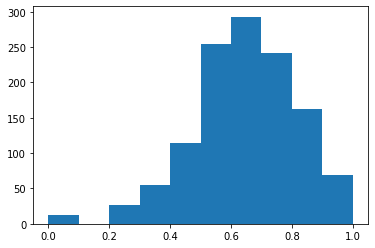

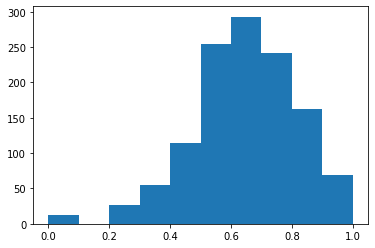

In [0]:
def filterColumnRange(data,column_name,lowerBound,upperBound):
  return data.loc[(data[column_name] >= lowerBound) & (data[column_name] <= upperBound)]

plt.hist(FinalData["Sentiment=Positive"])
plt.show()

plt.hist(FinalData["Sentiment=Positive"])
plt.show()

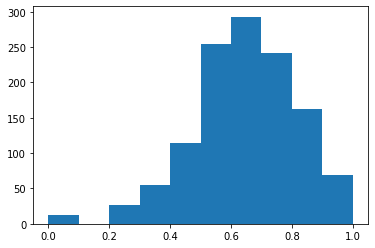

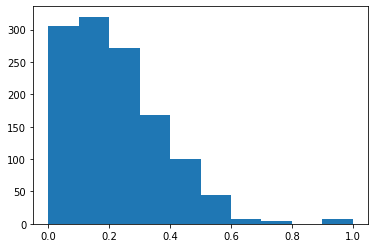

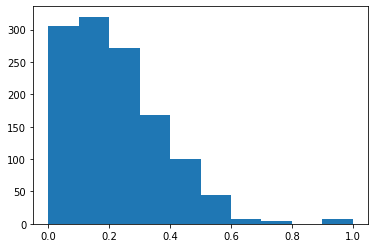

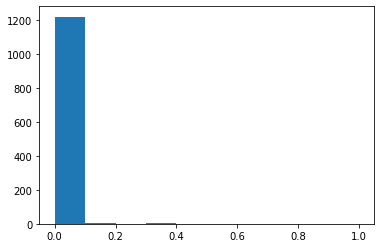

In [0]:
plt.hist(FinalData["Sentiment=Positive"])
plt.show()
plt.hist(FinalData["Sentiment=Negative"])
plt.show()
plt.hist(FinalData["Sentiment=Negative"])
plt.show()
plt.hist(FinalData["Price"])
plt.show()

FinalData = filterColumnRange(FinalData,"Sentiment=Neutral",0,.4)
FinalData = filterColumnRange(FinalData,"Sentiment=Positive",.2,1)
FinalData = filterColumnRange(FinalData,"Sentiment=Negative",0,.5)
FinalData = filterColumnRange(FinalData,"Price",0,.4)


Below are the three new sentiment score distribution after removing the outliers.

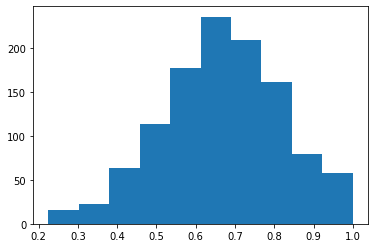

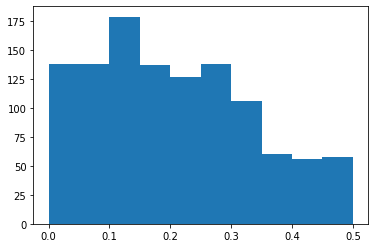

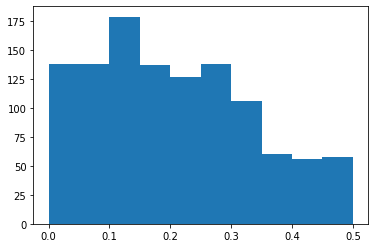

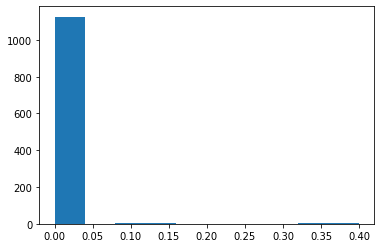

In [0]:

plt.hist(FinalData["Sentiment=Positive"])
plt.show()
plt.hist(FinalData["Sentiment=Negative"])
plt.show()
plt.hist(FinalData["Sentiment=Negative"])
plt.show()
plt.hist(FinalData["Price"])
plt.show()

In [0]:
for c in ["Price","Sentiment=Positive","Sentiment=Negative","Sentiment=Neutral"]:
  FinalData[c] = (FinalData[c] - min(FinalData[c])) / (max(FinalData[c])- min(FinalData[c]) )

In [0]:
FinalData.to_csv("drive/My Drive/CS3481Project2/adv_cleaned_google_app_data.csv",index=False)
FinalData.head()

,Installs,Type,Price,Cat&Genres=Shopping,Cat&Genres=Food & Drink,Cat&Genres=Puzzle,Cat&Genres=Casual,Cat&Genres=Educational,Cat&Genres=Personalization,Cat&Genres=Health & Fitness,Cat&Genres=Action,Cat&Genres=Arcade,Cat&Genres=Books & Reference,Cat&Genres=Photography,Cat&Genres=Dating,Cat&Genres=Racing,Cat&Genres=Communication,Cat&Genres=Business,Cat&Genres=Tools,Cat&Genres=Game,Cat&Genres=Pretend Play,Cat&Genres=Lifestyle,Cat&Genres=Productivity,Cat&Genres=Entertainment,Cat&Genres=Travel & Local,Cat&Genres=House & Home,Cat&Genres=News & Magazines,Cat&Genres=Family,Cat&Genres=Social,Cat&Genres=Brain Games,Cat&Genres=Education,Cat&Genres=Sports,Cat&Genres=Finance,Cat&Genres=Simulation,Cat&Genres=Medical,Cat&Genres=Role Playing,Cat&Genres=Action & Adventure,Content Rating=Everyone,Content Rating=Teen,Content Rating=Mature 17+,Sentiment=Positive,Sentiment=Neutral,Sentiment=Negative
0,500000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.472141,0.227273,0.636364
1,500000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.472141,0.227273,0.636364
2,1000000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.627240,0.444444,0.222222
3,5000000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.000000,0.000000,0.000000
4,100000,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.490662,0.657895,0.263158


#Fix Class Imbalance

For the distribution of install numbers we can observe that they have been rounded and that *number of installs = 1000* is very samll. This could cause problems when training the classification model. In order to improve this, we  dropped those rows to make the data more normal. We also combined these classes so there are no classes that appear too few times.


In [0]:
def catagories_class(x,classes):
  return classes.index(x)
def targetClassInstallsCatagories(Data):
  atributes = list(Data.columns)
  atributes.remove("Installs")
  x = Data[atributes]
  y = Data[["Installs"]]
  install_values = list(set(y["Installs"]))
  print(install_values)
  install_values.sort()
  y["Installs"] = y["Installs"].apply(catagories_class,args = (install_values,)) 
  return train_test_split(x,y["Installs"],test_size=.4)

def cutpoint(x,split):
  if x >=split:
    return 1
  else:
    return 0
def targetHits(Data):
  atributes = list(Data.columns)
  atributes.remove("Installs")
  x = Data[atributes]
  y = Data[["Installs"]]
  splitpoint = np.percentile(y,80)
  y["Installs"] = y["Installs"].apply(cutpoint,args = (splitpoint,)) 
  return train_test_split(x,y["Installs"],test_size=.4)

def replace_fives(x):
  return int(str(x).replace('5','1'))
def targetReduced(Data):
  Data["Installs"] = Data["Installs"].apply(replace_fives)
  Data = Data.loc[Data["Installs"] != 1000]
  return targetClassInstallsCatagories(Data)

def reducedInputVector(Data):
  atributes = list(Data.columns)
  atributes.remove("Installs")
  x = Data[atributes]
  y = Data[["Installs"]]
  install_values = list(set(y["Installs"]))
  print(install_values)
  install_values.sort()
  y["Installs"] = y["Installs"].apply(catagories_class,args = (install_values,)) 
  return train_test_split(x,y["Installs"],test_size=.6)

#Different Models

In order to test we will load the iris data as a sample set.

In [0]:
iris_data = pd.read_csv("drive/My Drive/CS3481Project2/iris.data",names = ["x1","x2","x3","x4","class"])
x_train,x_test,y_train,y_test = train_test_split(iris_data[["x1","x2","x3","x4"]],iris_data["class"],test_size=.4)

##ANN


Our first model to test is an Artificial neural network. Our optimizer will be set to Adam and we will use Categorical cross entropy as a loss function. For parameters we will change the learning rate, the number of training epochs and the structure of the model layers. This function trains and tests the network and saves the output to a dictionary for later analysis.

In [0]:
def RunAnnCatagory(

  learning_rate,epochs,model_size,
  x_train,y_train,x_test,y_test
):
  depth = len(set(list(y_test)+list(y_train)))
  y_test =  tf.one_hot( y_test ,depth  )
  y_train = tf.one_hot( y_train,   depth)
  model = Sequential()
  
  model.add(layers.Input(len(x_train.columns)))
  for layer_size in model_size:
    model.add(layers.Dense(layer_size,activation= 'sigmoid'))
  model.add(layers.Dense(y_test.shape[1],activation = 'softmax'))
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=[tf.keras.metrics.CategoricalAccuracy()])
  
  his = model.fit(x_train, y_train,batch_size = 32 , verbose = 0, epochs = epochs)

  
  pred = model.predict(x_test,)
  m = tf.keras.metrics.CategoricalAccuracy() 
  m.reset_states()
  m.update_state(y_test, pred)

  w = model.get_weights()
  for i in range(len(w)//2):
    layer = []
    for ii in range(len(w[i*2])):
      layer.append( ":".join(map(str,w[i*2][ii])) )
    w[i*2] = "::".join(layer)
    
    w[i*2+1]=":".join(map(str,w[i*2+1])) 

  wstring = ":::".join(w)

  log = {
      "input_features": ";".join(x_train.columns),

      "learning_rate":learning_rate,
      "epochs":epochs,
      "model_size":";".join(map(str,model_size)),

      "train_history_accuracy": ";".join(map(str,his.history["categorical_accuracy"])),
      "train_history_loss": ";".join(map(str,his.history["loss"])),

      "model": wstring,

      "train_accuracy": his.history["categorical_accuracy"][-1],
      "test_accuracy":  m.result().numpy(),

      
  }
  return log

  

In [0]:
log = RunAnnCatagory(0.1,100,[10],
       x_train,y_train,x_test,y_test)

##Tree

A second method we will be testing will be a decision tree. This again is a wrapping function that contains the training and test portions of the decision tree. we allow for changing max depth and min leaf size

In [0]:
def RunDecisionTreeCatagories (
    folds,
    _max_depth,leaf_size,
    x_train,y_train,x_test,y_test
  ):


  clf = DecisionTreeClassifier(max_depth = _max_depth, min_samples_leaf = leaf_size)
  scores = cross_val_score(clf, x_train.to_numpy(), y_train.to_numpy().ravel(), cv=folds)

  clf.fit(x_train,y_train)


  y_pred_train = clf.predict(x_train)
  train_accuracy = metrics.accuracy_score(y_train, y_pred_train)

  y_pred = clf.predict(x_test)
  test_accuracy = metrics.accuracy_score(y_test, y_pred)

  logs = {
      "input_features": ";".join(x_train.columns),
      "folds": folds,

      "min_leaf_size": leaf_size,
      "max_depth": _max_depth,

      "train_accuracy": train_accuracy,
      "test_accuracy": test_accuracy,

      "cross_val_acc": scores,
      "model": sklearn.tree.export_text(clf),

      "pred":";".join(map(str,y_pred[:20])),
      "y_hat":";".join(map(str,y_test[:20]))
  }
 
  return logs
  


In [0]:
RunDecisionTreeCatagories(5,
       None,5,
       x_train,y_train,x_test,y_test)

{'cross_val_acc': array([0.88888889, 0.88888889, 0.94444444, 0.94444444, 0.94444444]),
 'folds': 5,
 'input_features': 'x1;x2;x3;x4',
 'max_depth': None,
 'min_leaf_size': 5,
 'model': '|--- feature_3 <= 0.80\n|   |--- class: 0\n|--- feature_3 >  0.80\n|   |--- feature_2 <= 4.85\n|   |   |--- feature_2 <= 4.65\n|   |   |   |--- class: 1\n|   |   |--- feature_2 >  4.65\n|   |   |   |--- class: 1\n|   |--- feature_2 >  4.85\n|   |   |--- feature_3 <= 1.75\n|   |   |   |--- class: 2\n|   |   |--- feature_3 >  1.75\n|   |   |   |--- class: 2\n',
 'pred': '1;2;2;2;2;1;0;2;2;0;1;1;0;0;2;0;2;0;0;2',
 'test_accuracy': 0.95,
 'train_accuracy': 0.9555555555555556,
 'y_hat': '1;2;2;2;2;1;0;2;2;0;1;1;0;0;2;0;2;0;0;2'}

In [0]:
RunDecisionTreeCatagories(5,
       1000,.001,
       x_train,y_train,x_test,y_test)

{'cross_val_acc': array([0.88888889, 0.88888889, 0.94444444, 0.94444444, 0.94444444]),
 'folds': 5,
 'input_features': 'x1;x2;x3;x4',
 'max_depth': 1000,
 'min_leaf_size': 0.001,
 'model': '|--- feature_3 <= 0.80\n|   |--- class: 0\n|--- feature_3 >  0.80\n|   |--- feature_2 <= 4.85\n|   |   |--- feature_3 <= 1.70\n|   |   |   |--- class: 1\n|   |   |--- feature_3 >  1.70\n|   |   |   |--- feature_0 <= 6.05\n|   |   |   |   |--- class: 1\n|   |   |   |--- feature_0 >  6.05\n|   |   |   |   |--- class: 2\n|   |--- feature_2 >  4.85\n|   |   |--- feature_3 <= 1.75\n|   |   |   |--- feature_2 <= 5.35\n|   |   |   |   |--- feature_3 <= 1.55\n|   |   |   |   |   |--- feature_2 <= 4.95\n|   |   |   |   |   |   |--- class: 1\n|   |   |   |   |   |--- feature_2 >  4.95\n|   |   |   |   |   |   |--- class: 2\n|   |   |   |   |--- feature_3 >  1.55\n|   |   |   |   |   |--- class: 1\n|   |   |   |--- feature_2 >  5.35\n|   |   |   |   |--- class: 2\n|   |   |--- feature_3 >  1.75\n|   |   |   |-

#Parameter Searching

I order to maximize the accuracy of the model we want to preform searching across several different paramaters. we oviously will generate different paramaters for each of our training methods artificial nural network and decision tree, but we allso want to do atribute seleciton on the input feture. as there are so many columns it is likely that some columns will be less useful than others.

##Data

we have a number of ways to reduce the number of column/atributes we will be using the first method is to drop chunks of columns by there meaning on the other hand we can attempt to surmize what columns are best.

###Drop Columns Of Catagory

The first method for reduceing columns is to drop columns by catagories. we can just by what might feel irelement. below we design several functions to reduce the number columns by droping things like the sentiment score or the content ratings. In the end I decided against these methods as they seem to be the least effective and finding good solutions.

In [0]:
def drop_price(df):
  return df.drop(columns=["Price","Type"])
def drop_viewSorce(df):
  return df.drop(columns = ["Rating"])
def drop_sentiment(df):
  return df.drop(columns = [col for col in df if col.startswith('Sentiment=')])
def drop_Content_Rating(df):
  return df.drop(columns = [col for col in df if col.startswith('Content Rating=')])
def drop_Category_data(df):
  return df.drop(columns = [col for col in df if col.startswith('Cat&Genres=')])



###Automatic Column Selection

We can also attempt to find the best set of columns to do this we can test different subsets of columns to see how well they perform. Testing all combinations of attributes would be time consuming, but we can test some of them. I have two methods for detecting a good column set. First recursive drop where we test to what are the best subsets of n-1 elements and solving for the worst single element, then testing for the best n-2 elements automatically assuming that the worst element is already removed. We repeat this until we rank all the elements in order of usefulness. We can also perform this search in reverse finding the best singe element and adding one each iteration to maximize the accuracy. In that case we test all subset of 1 and find which is most effective. We can then build subsets of 2 that contain that single best column we already found. After we have done this, we now have two way to apply this knowledge. First we can exam in what order the columns we selected we can then attempts selecting the top n columns for our model. We could also try to select the subset set that tested best.

In [0]:
def SortedColumns_byRecrusiveDrop(x_train,y_train,clf,verbose=False):
  
  x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=.33)
  log = {
      "column_subset": [";".join(list(x_train.columns))],
      "accuracy_train":[statistics.mean(cross_val_score(clf, x_train.to_numpy(), y_train.to_numpy().ravel(), cv=10))],
      "accuracy_test":[]
  }
  
  clf.fit(x_train,y_train)
  log["accuracy_test"].append(metrics.accuracy_score(y_test, clf.predict(x_test)))

  ranked_list = []
  all_columns = list(x_train.columns)
  if(verbose):
    bar=tqdm(total = len(x_train.columns)*(len(x_train.columns)+1)/2-1,desc = "ranking-Drop" )
  while(len(all_columns)>1):

    round_scores = {
        
    }
    min_score = -1
    for column_name in all_columns:
      test_columns = all_columns.copy()
      test_columns.remove(column_name)
      test_scores = 0
      with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        test_scores = cross_val_score(clf, x_train[test_columns].to_numpy(), y_train.to_numpy().ravel(), cv=10)
      test_mean = statistics.mean(test_scores)
      #find_min
      if(test_mean<min_score  or min_score==-1):
        min_score=test_mean

      #records
      log["column_subset"].append(";".join(test_columns))
      log["accuracy_train"].append(test_mean)
      round_scores[column_name]=test_mean

      clf.fit(x_train[test_columns],y_train)
      log["accuracy_test"].append(metrics.accuracy_score(y_test, clf.predict(x_test[test_columns])))

      if(verbose):
        bar.update()
    for key in round_scores.keys():
      if(round_scores[key]==min_score):
        all_columns.remove(key)
        ranked_list.append(key)
        break;
  if(verbose):
    bar.close()

  ranked_list+=all_columns
  ranked_list.reverse()  

  log["accuracy_train"].append(0)
  log["accuracy_test"].append(0)
  log["column_subset"].append(";".join(ranked_list))
  return(ranked_list,pd.DataFrame(data=log))
def SortedColumns_byRecrusiveGain(x_train,y_train,clf,verbose=False):
    x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=.33)
    log = {
      "column_subset": [],
      "accuracy_train":[],
      "accuracy_test":[]
    }
    
    

    ranked_list = []
    UnusedColumns = list(x_train.columns)
    selected_columns = []
    if(verbose):
      SortedColumns_byRecrusiveGain_bar=tqdm(total = len(x_train.columns)*(len(x_train.columns)+1)/2-1,desc = "ranking-Gain" )
    while(len(UnusedColumns)>0):
      max_score = 0
      round_scores = {
          
      }
      
      for column_name in  UnusedColumns:
        test_columns = selected_columns.copy()
        test_columns.append(column_name)

        test_scores = 0
        with warnings.catch_warnings():
          warnings.simplefilter("ignore")
          test_scores = cross_val_score(clf, x_train[test_columns].to_numpy(), y_train.to_numpy().ravel(), cv=10)
        test_mean = statistics.mean(test_scores)
        
        #find_max
        if(test_mean>max_score):
          max_score=test_mean

        #records
        log["column_subset"].append(";".join(test_columns))
        log["accuracy_train"].append(test_mean)
        clf.fit(x_train[test_columns],y_train)
        log["accuracy_test"].append(metrics.accuracy_score(y_test, clf.predict(x_test[test_columns])))

        round_scores[column_name]=test_mean
        if(verbose):
          SortedColumns_byRecrusiveGain_bar.update(1)

      for key in round_scores.keys():
        if(round_scores[key]>=max_score):
          UnusedColumns.remove(key)
          selected_columns.append(key)
          ranked_list.append(key)
          break;

    if(verbose):
      SortedColumns_byRecrusiveGain_bar.close()

    log["accuracy_train"].append(0)
    log["accuracy_test"].append(0)
    log["column_subset"].append(";".join(ranked_list))
    return(ranked_list,pd.DataFrame(data=log))

      
Ranked_Atribute_List_Gain,Ranked_Atribute_Log_Gain = SortedColumns_byRecrusiveGain(x_train,y_train,DecisionTreeClassifier(),verbose=True)
Ranked_Atribute_List_Drop,Ranked_Atribute_Log_Drop = SortedColumns_byRecrusiveDrop(x_train,y_train,DecisionTreeClassifier(),verbose=True)




After we calculate all of our rank lists and subsets, we also want to do a bit of analysis to find what attributes are important so we mark what column subset at each count which was the best and shows its testing and training accuracy.

In [0]:
def make_marked_ranked_set(Ranked_Atribute_Log):
  Ranked_Atribute_Log["count"] = Ranked_Atribute_Log["column_subset"].apply(lambda x:len(x.split(';')))


  best_scores = Ranked_Atribute_Log[["count","accuracy_test"]]
  best_scores=best_scores.groupby("count").max()
  Ranked_Atribute_Log_marked=Ranked_Atribute_Log.merge(best_scores,on = "count")
  Ranked_Atribute_Log_marked["best"] = Ranked_Atribute_Log_marked.accuracy_test_x == Ranked_Atribute_Log_marked.accuracy_test_y
  Ranked_Atribute_Log_marked = Ranked_Atribute_Log_marked.drop(columns=['accuracy_test_y'])
  Ranked_Atribute_Log_marked=Ranked_Atribute_Log_marked.rename(columns={"accuracy_test_x":"accuracy_test"})
  Ranked_Atribute_Log_marked=Ranked_Atribute_Log_marked.sort_values('accuracy_test',ascending=False)

  Ranked_Atribute_Log_marked.reset_index(inplace=True)
  return Ranked_Atribute_Log_marked
make_marked_ranked_set(Ranked_Atribute_Log_Gain)

,index,column_subset,accuracy_train,accuracy_test,count,best
0,3,x4,0.883333,0.966667,1,True
1,2,x3,0.916667,0.933333,1,False
2,4,x3;x1,0.900000,0.933333,2,True
3,6,x3;x4,0.916667,0.933333,2,True
4,8,x3;x2;x4,0.916667,0.933333,3,True
5,9,x3;x2;x4;x1,0.916667,0.933333,4,True
6,7,x3;x2;x1,0.900000,0.900000,3,False
7,5,x3;x2,0.916667,0.800000,2,False
8,0,x1,0.683333,0.700000,1,False
9,1,x2,0.516667,0.633333,1,False


In [0]:
make_marked_ranked_set(Ranked_Atribute_Log_Drop)

,index,column_subset,accuracy_train,accuracy_test,count,best
0,0,x1;x2;x3;x4,0.900000,0.933333,4,True
1,2,x2;x3;x4,0.916667,0.933333,3,True
2,3,x1;x3;x4,0.916667,0.933333,3,True
3,6,x2;x4,0.866667,0.933333,2,True
4,5,x1;x2;x3,0.900000,0.900000,3,False
5,4,x1;x2;x4,0.850000,0.866667,3,False
6,7,x1;x4,0.866667,0.833333,2,False
7,8,x1;x2,0.766667,0.600000,2,False
8,9,x2,0.466667,0.533333,1,True
9,10,x1,0.733333,0.533333,1,True


The graph below shows the effect of the ranked list approach. When we do this, we take the first n attributes from the best list for our subset. We graph the result as the number of attributes against the train accuracy. As you can see there is a small difference in the gain and drop methods.

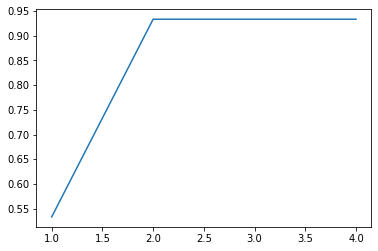

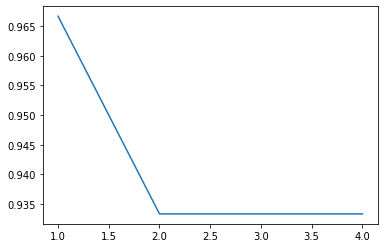

In [0]:


def graphRanking(ranking_log_marked):
  bestlist = ranking_log_marked.groupby("count",as_index=False).max().sort_values("count")
  

  plt.plot(bestlist["count"],bestlist["accuracy_test"])
  plt.show()



graphRanking(make_marked_ranked_set(Ranked_Atribute_Log_Drop)) 
graphRanking(make_marked_ranked_set(Ranked_Atribute_Log_Gain)) 

We can also just sort the subsets by their training accuracy and select the best subset we can see what hat looks like here. 

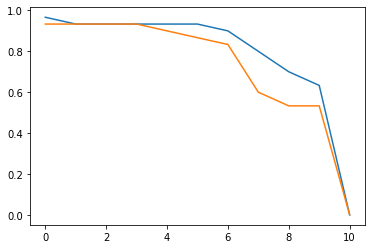

In [0]:
plt.plot(make_marked_ranked_set(Ranked_Atribute_Log_Gain)["accuracy_test"])
plt.plot(make_marked_ranked_set(Ranked_Atribute_Log_Drop)["accuracy_test"])

Finally, we create functions so that these modifications can be made dynamically. We also store our found data into a dictionary for furniture usage. For different function we have apply ranked gain which selects the n best attributes according to the recursive gain, and ranked drop is the same for the recursive drop method. We also can search for the best column subsets we found by soring the list by test accuracy. Apply best gain get the nth best column subset according to the recursive gain method while apply best drop is the same thing for the recursive drop method.

In [0]:


def createRanking(x_train,y_train,clf,verbose=False):
  Ranked_Atribute_List_Gain,Ranked_Atribute_Log_Gain = SortedColumns_byRecrusiveGain(x_train,y_train,clf,verbose=verbose)
  Ranked_Atribute_List_Drop,Ranked_Atribute_Log_Drop = SortedColumns_byRecrusiveDrop(x_train,y_train,clf,verbose=verbose)
  ranking_dict = {
    "Ranked_Atribute_List_Gain":Ranked_Atribute_List_Gain,
    "Ranked_Atribute_List_Drop":Ranked_Atribute_List_Drop,
    "Ranked_Atribute_Log_Drop": make_marked_ranked_set(Ranked_Atribute_Log_Drop),
    "Ranked_Atribute_Log_Gain":make_marked_ranked_set(Ranked_Atribute_Log_Gain)
  }
  return ranking_dict

def apply_ranked_gain(Data,count,ranking_dict):
  return Data[ranking_dict["Ranked_Atribute_List_Gain"][:count]]
def apply_ranked_drop(Data,count,ranking_dict):
  return Data[ranking_dict["Ranked_Atribute_List_Drop"][:count]]
def apply_best_gain(Data,count,ranking_dict):
  return Data[ranking_dict["Ranked_Atribute_Log_Gain"]["column_subset"][count].split(";")]
def apply_best_drop(Data,count,ranking_dict):
  return Data[ranking_dict["Ranked_Atribute_Log_Drop"]["column_subset"][count].split(";")]






###Application Functions

Now we need to mix and match these filters and come up with a list of different attributes sets to test. this filter combos are a list of strings that represent what actions to do to the data before training and testing the models with [ ] meaning nothing. I change this list all the time as I look for good solutions so there are likely many commented out plans that I deemed not worth testing further.

In [0]:

filter_combos = [
  [],
 #["drop_price"],
 #["drop_viewSorce"],
 #["drop_Content_Rating"],
 #["drop_Category_data"],
 #["drop_Category_data","drop_Content_Rating"],
 #["drop_price","drop_viewSorce","drop_Content_Rating","drop_Category_data"],
 #["drop_price","drop_viewSorce","drop_Content_Rating"],
 #["drop_price","drop_Content_Rating","drop_Category_data"],
]
filter_combos.extend([["apply_ranked_gain-"+str(i*5+20)] for i in range(4)])
filter_combos.extend([["apply_ranked_drop-"+str(i*5+20)] for i in range(4)])
filter_combos.extend([["apply_best_gain-"+str(i)] for i in range(5)])
filter_combos.extend([["apply_best_drop-"+str(i)] for i in range(5)])
#filter_combos.extend([["reduce_data-"+str(i*10+70)] for i in range(2)])
#reduced_load

'''filter_combos = [
  [],
 ["drop_Category_data","drop_Content_Rating"],
 ["drop_price","drop_viewSorce","drop_Content_Rating"],
 ["apply_best_gain-1"],
 ["apply_best_drop-1"],
 ["apply_ranked_drop-10"],
 ["apply_ranked_gain-10"],
]'''

function_definitions = {
    "drop_price":drop_price,
    "drop_viewSorce":drop_viewSorce,
    "drop_Content_Rating":drop_Content_Rating,
    "drop_Category_data":drop_Category_data,
    "apply_ranked_gain":apply_ranked_gain,
    "apply_ranked_drop":apply_ranked_drop,
    "apply_best_gain":apply_best_gain,
    "apply_best_drop":apply_best_drop,
}






def applyFilters(Data,filter_functions,ranking_dict):
  if(len(filter_functions)>0):
    
  
      for func in filter_functions:
        if("-" in func):
          Data = function_definitions[filter_functions[0].split('-')[0]](Data,int(filter_functions[0].split("-")[1]),ranking_dict)
        else:
          Data = function_definitions[func](Data)
  return Data

##ANN

For the artificial neural network, we vary the layer designs, the epochs, and learning rates. We store this information in a list of dictionaries. We try to search a variety of different layer formats and learning rates we also try several very long epochs number with very small learning rates I don’t train to many as they are the slowest.

In [0]:
model_designs = [
                 [10],
                 [32],
                 [64],
                 [32,32],
                 [64,64],
                 [100],
#                 [100,100]
                 ]
epochs = [500,250]
learning_rates = [0.1,0.01]

#reduced_load
#model_designs = [
#                 [10],
#                 [32],
#                 ]
#epochs = [200]
#learning_rates = [0.1,0.001]
ANN_trails = []
ANN_trails.append({
    "epochs":800,
    "learning_rate":0.001,
    "model":[32]
})
ANN_trails.append({
    "epochs":800,
    "learning_rate":0.001,
    "model":[64]
})
ANN_trails.append({
    "epochs":800,
    "learning_rate":0.001,
    "model":[10,10]
})

for model_ in model_designs:
  for epoch in epochs:
    for learning_rate in learning_rates:
      
      ANN_trails.append({
          "epochs":epoch,
          "learning_rate":learning_rate,
          "model": model_
      })
print(ANN_trails)

[{'epochs': 800, 'learning_rate': 0.001, 'model': [32]}, {'epochs': 800, 'learning_rate': 0.001, 'model': [64]}, {'epochs': 800, 'learning_rate': 0.001, 'model': [10, 10]}, {'epochs': 500, 'learning_rate': 0.1, 'model': [10]}, {'epochs': 500, 'learning_rate': 0.01, 'model': [10]}, {'epochs': 250, 'learning_rate': 0.1, 'model': [10]}, {'epochs': 250, 'learning_rate': 0.01, 'model': [10]}, {'epochs': 500, 'learning_rate': 0.1, 'model': [32]}, {'epochs': 500, 'learning_rate': 0.01, 'model': [32]}, {'epochs': 250, 'learning_rate': 0.1, 'model': [32]}, {'epochs': 250, 'learning_rate': 0.01, 'model': [32]}, {'epochs': 500, 'learning_rate': 0.1, 'model': [64]}, {'epochs': 500, 'learning_rate': 0.01, 'model': [64]}, {'epochs': 250, 'learning_rate': 0.1, 'model': [64]}, {'epochs': 250, 'learning_rate': 0.01, 'model': [64]}, {'epochs': 500, 'learning_rate': 0.1, 'model': [32, 32]}, {'epochs': 500, 'learning_rate': 0.01, 'model': [32, 32]}, {'epochs': 250, 'learning_rate': 0.1, 'model': [32, 32]}

##DecisionTree

The decision tree has a much smaller number of attributes and I have found that using the defaults tends to do very well. Likely because the column selection is done with a default tree.

In [0]:
leaf_sizes = [2,5,10,20]
max_depths = [None]
#reduced_load
#leaf_sizes = [2,6]
#max_depths = [None]

Tree_trails = []
for leaf_size in leaf_sizes:
  for max_depth in max_depths:
    Tree_trails.append({
        "leaf_size":leaf_size,
         "max_depth":max_depth,
    })
print(Tree_trails)

[{'leaf_size': 2, 'max_depth': None}, {'leaf_size': 5, 'max_depth': None}, {'leaf_size': 10, 'max_depth': None}, {'leaf_size': 20, 'max_depth': None}]


#Training

##Wrap Training Functions

In order to preserve the data for future reading we save each trail to a unique location so that we can later review the data. we also can use this to check is this combination has been tested before and skip it this allows us to resume if anything goes wrong during the training process.

In [0]:

def runANNTrials(file_path,pram_dict,input_functions,x_train,y_train,x_test,y_test):

  write_location = file_path + "ANN"
  for key in pram_dict:
    write_location += ("|" + str(pram_dict[key]))
  
  if not Path(write_location+".csv").is_file():
    log = RunAnnCatagory(
      pram_dict["learning_rate"],pram_dict["epochs"],pram_dict["model"],
      x_train,y_train,x_test,y_test
    )

    for key in log:
      log[key] = [log[key]]
    to_write=pd.DataFrame(data = log)
    to_write["input_functions"] = input_functions
    to_write.to_csv(write_location+".csv",index=False)
  else:
    pass

runANNTrials("h",{"learning_rate":0.1,"epochs":10,"model":[10]},"NONE",x_train,y_train,x_test,y_test)


In [0]:
def runTreeTrials(file_path,pram_dict,input_functions,x_train,y_train,x_test,y_test):

  write_location = file_path + "Tree"
  for key in pram_dict:
    write_location += ("|" + str(pram_dict[key]))
  write_location+=".csv"
  if not Path(write_location).is_file():
    log = RunDecisionTreeCatagories (
      5,
      pram_dict["max_depth"], pram_dict["leaf_size"],
      x_train,y_train,x_test,y_test
    )

    for key in log:
      log[key] = [log[key]]
    to_write=pd.DataFrame(data = log)
    to_write["input_functions"] = input_functions
    to_write.to_csv(write_location,index=False)
  else:
    pass


runTreeTrials("h",{"max_depth":None,"leaf_size":10},"NONE",x_train,y_train,x_test,y_test)

##Training loop

Now we put all the functions together to search for a good model for the data. One of the first things we do is declare the save location for the data. Next calculate the ranking list and best gain and drop search on the training data. Next, we loop through all the different combinations of data filters and training of the ANN and tree and finally we save the ranking logs.

In [0]:

folder = "ClassFixColumnFix"#"EXClassFixNoColumnFix","EXClassFixColumnFix"
for folder in ["noClassFixNoColumnFix","noClassFixColumnFix","ClassFixNoColumnFix","ClassFixColumnFix"]:

  #worst no cleaning or column removal
  if(folder == "noClassFixNoColumnFix"):
    Cleaned_data = pd.read_csv("drive/My Drive/CS3481Project2/basic_cleaned_google_app_data.csv",sep = ',')
    x_train_orig,x_test_orig,y_train_orig,y_test_orig = targetClassInstallsCatagories(Cleaned_data)
  #clean the columns but no data row fixing
  if(folder == "noClassFixColumnFix"):
    Cleaned_data = pd.read_csv("drive/My Drive/CS3481Project2/adv_cleaned_google_app_data.csv",sep = ',')
    x_train_orig,x_test_orig,y_train_orig,y_test_orig = targetClassInstallsCatagories(Cleaned_data)
  #clean class but raw data
  if(folder == "ClassFixNoColumnFix"):
    Cleaned_data = pd.read_csv("drive/My Drive/CS3481Project2/basic_cleaned_google_app_data.csv",sep = ',')
    x_train_orig,x_test_orig,y_train_orig,y_test_orig = targetReduced(Cleaned_data)
  #best both reduce column and class
  if(folder == "ClassFixColumnFix"):
    Cleaned_data = pd.read_csv("drive/My Drive/CS3481Project2/adv_cleaned_google_app_data.csv",sep = ',')
    x_train_orig,x_test_orig,y_train_orig,y_test_orig = targetReduced(Cleaned_data)

  if(folder == "EXClassFixColumnFix"):
    Cleaned_data = pd.read_csv("drive/My Drive/CS3481Project2/adv_cleaned_google_app_data.csv",sep = ',')
    x_train_orig,x_test_orig,y_train_orig,y_test_orig = targetHits(Cleaned_data)
  if(folder == "EXClassFixNoColumnFix"):
    Cleaned_data = pd.read_csv("drive/My Drive/CS3481Project2/basic_cleaned_google_app_data.csv",sep = ',')
    x_train_orig,x_test_orig,y_train_orig,y_test_orig = targetHits(Cleaned_data)

  file_base = "drive/My Drive/CS3481Project2/"+folder+"/"



  ranking_dict = createRanking(x_train_orig,y_train_orig,DecisionTreeClassifier(min_samples_leaf = 5),verbose=True)

  totalruns = len(filter_combos)*(len(ANN_trails)+len(Tree_trails))

  filter_bar = tqdm(total = len(filter_combos),desc = "Total")

  for filted_set in filter_combos:
    x_train = applyFilters(x_train_orig,filted_set,ranking_dict)
    x_test = applyFilters(x_test_orig,filted_set,ranking_dict)
    y_train = y_train_orig
    y_test = y_test_orig
    
    filter_name = "|".join(filted_set)

    ANN_bar = tqdm(total = len(ANN_trails),desc = "ANN:Training")
    for ANN_trail in ANN_trails:
      runANNTrials(file_base+filter_name,ANN_trail,filter_name,x_train,y_train,x_test,y_test)
      ANN_bar.update(1)
    ANN_bar.close()
    TREE_bar = tqdm(total = len(Tree_trails), desc = "TREE: Training" )
    for Tree_trail in Tree_trails:
      runTreeTrials(file_base+filter_name,Tree_trail,filter_name,x_train,y_train,x_test,y_test)
      TREE_bar.update(1)
    TREE_bar.close()

  filter_bar.close()
  ranking_dict["Ranked_Atribute_Log_Drop"].to_csv(file_base+"Ranked_Atribute_Log_Drop.csv")
  ranking_dict["Ranked_Atribute_Log_Gain"].to_csv(file_base+"Ranked_Atribute_Log_Gain.csv")

#Rejoin the data

to recollect the data we search through all the sections of data and join them in to two tables with all the information

In [0]:

ANN_Data = None
ANN_Data_first = True

TREE_Data = None
TREE_Data_first = False



folders = ["noClassFixNoColumnFix","noClassFixColumnFix","ClassFixNoColumnFix","ClassFixColumnFix"]


joiningBar = tqdm(total = len(folders)*len(filter_combos)*(len(ANN_trails)+len(Tree_trails)),desc = "merging")

for folder in folders:
  file_base = "drive/My Drive/CS3481Project2/"+folder+"/"
  for filted_set in filter_combos:
    filter_name = "|".join(filted_set)
    for ANN_trail in ANN_trails:
      write_location="ANN"
      for key in ANN_trail:
        write_location += ("|" + str(ANN_trail[key]))
      try:
        file_row = pd.read_csv(file_base+filter_name+write_location+".csv")
        file_row["folder"] = folder
        if(ANN_Data_first==True):
          ANN_Data = file_row
          ANN_Data_first = False
        else:
          ANN_Data = pd.concat([ANN_Data,file_row])
      except:
        print(file_base+filter_name+write_location+".csv")
      joiningBar.update()
    for Tree_trail in Tree_trails:
      write_location="Tree"
      for key in Tree_trail:
        write_location += ("|" + str(Tree_trail[key]))
      try:
        file_row = pd.read_csv(file_base+filter_name+write_location+".csv")
        file_row["folder"] = folder
        if(TREE_Data_first==True):
          TREE_Data = file_row
          TREE_Data_first = False
        else:
          TREE_Data = pd.concat([TREE_Data,file_row])
      except:
        print("r")
      joiningBar.update(1)
joiningBar.close()
ANN_Data.to_csv("drive/My Drive/CS3481Project2/ANN_DATA.csv")
TREE_Data.to_csv("drive/My Drive/CS3481Project2/TREE_DATA.csv")

In [0]:
ANN_Data = pd.read_csv("drive/My Drive/CS3481Project2/ANN_DATA.csv")
TREE_Data = pd.read_csv("drive/My Drive/CS3481Project2/TREE_DATA.csv")

#Analyse results

In [0]:
print(max(ANN_Data["test_accuracy"]))
print(max(TREE_Data["test_accuracy"]))

##Initial results
Bellow we can see the results of the simplest classifiers made

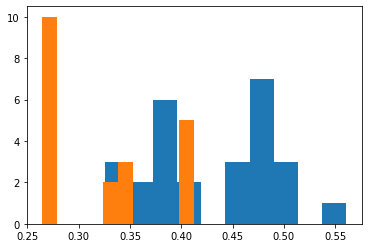

In [0]:
plt.hist(ANN_Data.loc[(ANN_Data["folder"] == "noClassFixNoColumnFix") & ANN_Data["input_functions"].isnull() ]["test_accuracy"])
plt.hist(TREE_Data.loc[(TREE_Data["folder"] == "noClassFixNoColumnFix") & TREE_Data["input_functions"].isnull() ]["test_accuracy"])
plt.show()

##After Advanced Cleaning

Now, after we remove the outliers of both classes and columns, we can see there is improvement on the testing accuracy. Both the Tree and ANN methods have test accuracy improvement by around 11%.<br><br>
However, the charts do not really show the truth. Because we reduce the number of classes. We can think of the model changing from answering a multiple choice problem to a True of False problem. a random guesser in multiple choice is expected to get 25% right in true or false we should see that rise to 50% . In our previous testing area there was a majority class containing 24%, so a majority guess should get 24%, now the majority class is 35%. meaning the guessing majority class has improved by 11%. Since it is easier to classify the data, the accuracy should automatically rise.


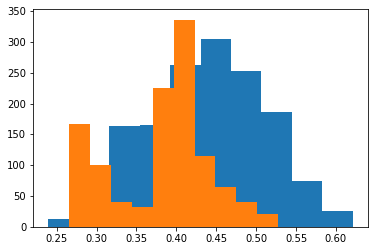

In [0]:
plt.hist(ANN_Data.loc[(ANN_Data["folder"] != "noClassFixNoColumnFix") ]["test_accuracy"])
plt.hist(TREE_Data.loc[(TREE_Data["folder"] != "noClassFixNoColumnFix")]["test_accuracy"])
plt.show()

##Graphing of Sentiment

Before removing the outliers. We can take a look at the original sentiment scores and see if it is related to the number of installs. From the first graph below we can see that each sentiment has data clustering together. and some people would say that it is a trend.<br><br>
Now, once we removed the outliers. The data points in the below second graph are more uniformly distributed and there seem to be no trend. There are two reasons behind this result. First, it might be that there is no trend at all showing relation of sentiment scores and number of installs. Second, when we were doing the second data cleaning process, we might remove the outliers which contain all the trends. However, if the outliers are the only trend, then those shouldn’t be considered as trends.

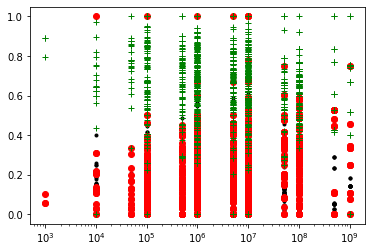

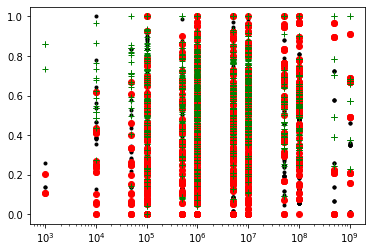

In [0]:
original = pd.read_csv("drive/My Drive/CS3481Project2/basic_cleaned_google_app_data.csv",sep = ',')
adv_clean = pd.read_csv("drive/My Drive/CS3481Project2/adv_cleaned_google_app_data.csv",sep = ',')
plt.plot(original["Installs"],original["Sentiment=Neutral"],'k.')
plt.plot(original["Installs"],original["Sentiment=Negative"],'ro')
plt.plot(original["Installs"],original["Sentiment=Positive"],'g+')
plt.xscale('log')
plt.show()

plt.plot(adv_clean["Installs"],adv_clean["Sentiment=Neutral"],'k.')
plt.plot(adv_clean["Installs"],adv_clean["Sentiment=Negative"],'ro')
plt.plot(adv_clean["Installs"],adv_clean["Sentiment=Positive"],'g+')
plt.xscale('log')
plt.show()



In [0]:
ANN_Data.sort_values("test_accuracy", ascending= False, inplace = True)
ANN_Data.loc[(ANN_Data.folder == "noClassFixNoColumnFix") |(ANN_Data.folder == "noClassFixColumnFix") ].head(2)

,input_features,learning_rate,epochs,model_size,train_history_accuracy,train_history_loss,model,train_accuracy,test_accuracy,input_functions,folder
0,Type;Price;Cat&Genres=Entertainment;Cat&Genres...,0.01,500,64;64,0.22659429907798767;0.2333785593509674;0.23337...,2.1908085346221924;2.1951000690460205;2.061595...,0.04338289:0.0036568744:-0.022672404:-0.162045...,0.947083,0.560976,NaN,noClassFixNoColumnFix
0,Type;Price;Cat&Genres=Entertainment;Cat&Genres...,0.01,500,64;64,0.20895522832870483;0.21845318377017975;0.2035...,2.2479872703552246;2.076768159866333;2.1028654...,-0.7376869:1.0140544:-0.3545434:1.2096585:-0.1...,0.886024,0.532520,apply_best_drop-0,noClassFixNoColumnFix


##Column Reduction Analysis

We can look at how effect the different column selection methods were at improve the model’s accuracy. We exam how models without column selection compared to the models with column selection we can see from this that most of the time we did not really improve the model, but there were a lot of times where we increased performance by a few point. 

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


[['apply_ranked_gain', 0.025220264317180607, 0.025220264317180607, 0.025220264317180607, 0.025220264317180607, 0.025220264317180607, 0.018800813008130024, 0.018800813008130024, 0.018800813008130024, 0.018800813008130024, 0.018800813008130024, 0.018800813008130024, 0.018800813008130024, 0.018800813008130024, 0.018800813008130024, 0.018800813008130024, 0.014735772357723553, 0.014735772357723553, 0.014735772357723553, 0.014735772357723553, 0.014735772357723553, 0.012004405286343611, 0.012004405286343611, 0.012004405286343611, 0.012004405286343611, 0.010670731707317027, 0.010670731707317027, 0.010670731707317027, 0.010670731707317027, 0.010670731707317027, 0.010670731707317027, 0.010670731707317027, 0.010670731707317027, 0.010670731707317027, 0.010670731707317027, 0.010670731707317027, 0.010670731707317027, 0.010670731707317027, 0.010670731707317027, 0.010670731707317027, 0.010670731707317027, 0.010670731707317027, 0.010670731707317027, 0.010670731707317027, 0.010670731707317027, 0.0086382

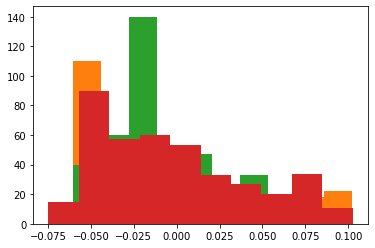

In [0]:
dcf = TREE_Data.copy()
df=dcf.loc[dcf["input_functions"].isnull()==False]
df = df[["folder","input_functions","test_accuracy"]]
root = dcf.loc[dcf["input_functions"].isnull()]
root = root[["folder","input_functions","test_accuracy"]]
df["input_functions"] = df["input_functions"].apply(lambda x: x.split("-")[0])
#df = df.groupby(["folder","input_functions"],as_index= False).agg({"test_accuracy":["max","min","mean"]})
root = root.groupby(["folder"], as_index= False).agg({"test_accuracy":["max","min","mean"]})
comp = root.merge(df,on="folder")

#comp["improvment"] = comp[("test_accuracy_y","mean")]-comp[("test_accuracy_x","mean")]
comp["improvment"] = comp["test_accuracy"]-comp[("test_accuracy","mean")]
comp.sort_values(["improvment"],ascending = [False],inplace=True)

graph_data=[["apply_ranked_gain"] +list(comp.loc[comp["input_functions"] == "apply_ranked_gain"][("improvment")]),
    ["apply_ranked_drop"] +list(comp.loc[comp["input_functions"] == "apply_ranked_drop"][("improvment")]),
    ["apply_best_gain"] +list(comp.loc[comp["input_functions"] == "apply_best_gain"][("improvment")]),
    ["apply_best_drop"] +list(comp.loc[comp["input_functions"] == "apply_best_drop"][("improvment")]),]
for i in range(len(graph_data)):
  graph_data[i] = ",".join(map(str,graph_data[i]))
with open("tree_reducer_data.csv","w") as file:
  file.write("\n".join(graph_data))
plt.hist(list(comp.loc[comp["input_functions"] == "apply_ranked_gain"][("improvment")]))
plt.hist(list(comp.loc[comp["input_functions"] == "apply_ranked_drop"][("improvment")]))
plt.hist(list(comp.loc[comp["input_functions"] == "apply_best_gain"][("improvment")]))
plt.hist(list(comp.loc[comp["input_functions"] == "apply_best_drop"][("improvment")]))
plt.show()

###Examining the Ranking Methods


Graphing the effectiveness of the ranking methods show how the gain method performed significantly better than the loss method. Notice how quickly the accuracy drops off.

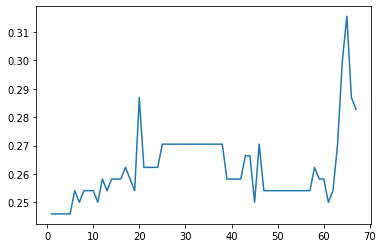

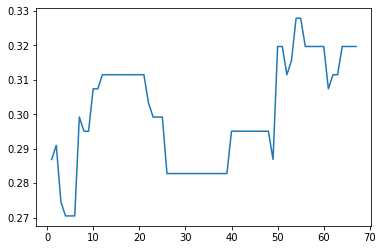

In [0]:
gainlog  = pd.read_csv("drive/My Drive/CS3481Project2/"+"noClassFixNoColumnFix"+"/Ranked_Atribute_Log_Gain.csv")
droplog = pd.read_csv("drive/My Drive/CS3481Project2/"+"noClassFixNoColumnFix"+"/Ranked_Atribute_Log_Drop.csv")
graphRanking(droplog)
graphRanking(gainlog)

###Examining the Best Selection Methods

In the best subset method we can still see the gain method being slightly better than the drop method however it is clear that this type of selection was much better than the ranked approach in the problem


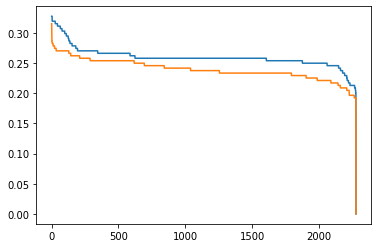

In [0]:
gainlog  = pd.read_csv("drive/My Drive/CS3481Project2/"+"noClassFixNoColumnFix"+"/Ranked_Atribute_Log_Gain.csv")
droplog = pd.read_csv("drive/My Drive/CS3481Project2/"+"noClassFixNoColumnFix"+"/Ranked_Atribute_Log_Drop.csv")
plt.plot(gainlog["accuracy_test"])
plt.plot(droplog["accuracy_test"])

I also like to point out this strange occurrence when we reduced the outliers in the advanced clean the system we can see that column selection seems to be doing better though this may not be very significant for our problem.

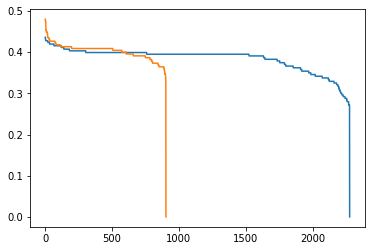

In [0]:
gainlog  = pd.read_csv("drive/My Drive/CS3481Project2/"+"ClassFixNoColumnFix"+"/Ranked_Atribute_Log_Gain.csv")
gainlogCfix  = pd.read_csv("drive/My Drive/CS3481Project2/"+"ClassFixColumnFix"+"/Ranked_Atribute_Log_Gain.csv")
plt.plot(gainlog["accuracy_test"])
plt.plot(gainlogCfix["accuracy_test"])


What was the least valuable column?

In [0]:
gainlogCfix["column_subset"].values[-1].split(";")

['Cat&Genres=Game',
 'Cat&Genres=Communication',
 'Cat&Genres=Tools',
 'Cat&Genres=Shopping',
 'Cat&Genres=Productivity',
 'Cat&Genres=Action & Adventure',
 'Cat&Genres=Photography',
 'Cat&Genres=Social',
 'Type',
 'Price',
 'Cat&Genres=Family',
 'Cat&Genres=Personalization',
 'Cat&Genres=Travel & Local',
 'Cat&Genres=Books & Reference',
 'Cat&Genres=Arcade',
 'Cat&Genres=Dating',
 'Cat&Genres=Role Playing',
 'Cat&Genres=Brain Games',
 'Cat&Genres=Entertainment',
 'Cat&Genres=House & Home',
 'Cat&Genres=Simulation',
 'Cat&Genres=Lifestyle',
 'Cat&Genres=Educational',
 'Cat&Genres=Racing',
 'Cat&Genres=Puzzle',
 'Content Rating=Mature 17+',
 'Cat&Genres=Finance',
 'Cat&Genres=Casual',
 'Cat&Genres=Education',
 'Cat&Genres=Pretend Play',
 'Cat&Genres=Medical',
 'Cat&Genres=Action',
 'Cat&Genres=Business',
 'Cat&Genres=Food & Drink',
 'Cat&Genres=News & Magazines',
 'Cat&Genres=Sports',
 'Cat&Genres=Health & Fitness',
 'Content Rating=Everyone',
 'Content Rating=Teen',
 'Sentiment=Negativ

Great job sentiment you are such a useful statistic.

#Conclusion

This problem was very difficult as it seems nothing we did was able to increase the score. This is likely because the people don’t really know what they want and often the best product such as the one with the best reviews doesn't actually do that well. We can see from the sentiment graphing that there seemed not to be any major correlation between good reviews and installs. A possible way this project could have been more successful was an early focus on changing to a regression problem as while the data while grouped could be turned back into a number. In the end the best we could do with all the classes was 56% with the Network and the best tree was 42%. With the reduced classes the best we could achieve was 62% with the ANN and 52% with the Tree. Overall getting even 62% seems unsuccessful it is not very far from just majority guessing. But I suspect it would be difficult to achieve higher results; none of the attributes seems to be able to predict the installs well. However calling the project a complete failure is not correct as we were able to find some methods to improve the accuracy through column selection and while we made the problem easier by reducing the number of class.it became more consistent. an easier problem with higher success would be a safer bet for those looking to invest. 
